# Лінійна регресія: перенавчання та регуляризація


У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

У всіх комірках, де написано коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Інші комірки з кодом (без коментарів) потрібно просто виконати. Крім того, у завданні потрібно відповідати на запитання; відповіді слід вписувати після виділеного слова "__Відповідь:__".

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, в якому денно записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів цього дня. Останнє ми передбачатимемо; таким чином, ми вирішуватимемо завдання регресії.

### Знайомство з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися у коректному зчитуванні даних:

In [3]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі атрибути:
* _season_: 1 - весна, 2 - літо, 3 - осінь, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: від 1 до 12
* _holiday_: 0 - немає свята, 1 - є свято
* _weekday_: від 0 до 6
* _workingday_: 0 - неробочий день, 1 - робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях на годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова змінна, її ми передбачатимемо)

Отже, у нас є речові, бінарні та номінальні (порядкові) параметри, і з усіма з них можна працювати як із речовими. З номінальними ознаками теж можна працювати як із речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від інших

Побудуйте графіки залежностей атрибутів від кількості подорожей. Тобто, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність відповідного атрибуту від змінної **cnt**.

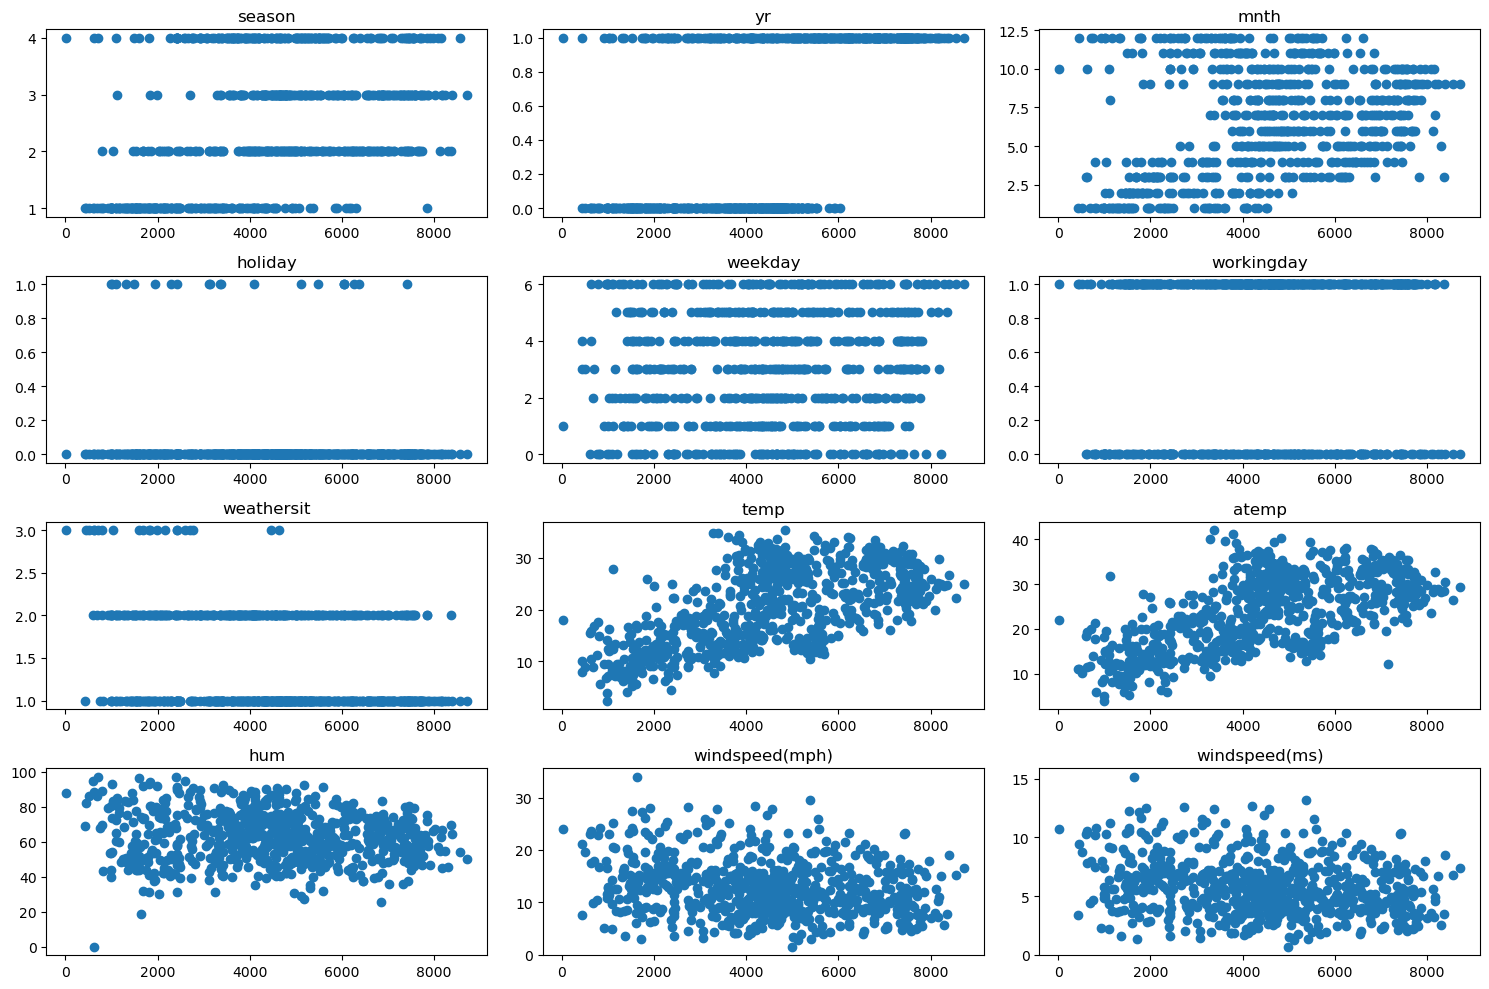

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 3, figsize=(15, 10))
axs = axs.ravel()

for i, col in enumerate(df.columns[:-1]):
    axs[i].scatter(df['cnt'],df[col])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()


__Питання:__
1. Що можна сказати про залежність прокатів від місяця?

липень-жовтень найбільш популярні місяці коли беруть прокат 

2. Вкажіть одну чи дві ознаки, від яких кількість прокатів швидше за все залежить лінійно

вологість чи швидкість вітру

## Завдання 2

Давайте більш строго оцінимо лінійність залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в пандах можна використовувати методи датафрейму: corr і corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [5]:
df.corrwith(df['cnt']).drop('cnt')


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

У вибірці є атрибути, що корелюють із цільовим, а отже, завдання можна вирішувати лінійними методами.

За графіками видно, що деякі атрибути схожі одне на одного. Тому давайте також порахуємо кореляції між речовими атрибутами.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) та cnt
за допомогою методу corr:

In [6]:
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()


,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналі, як їм і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (бо це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно впливає на навчання лінійної моделі.

Насамкінець, подивимося середні значення ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні значення атрибутів

In [7]:
df.mean()


season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різні порядки (різний масштаб), отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, в наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б відразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо його середнє і поділимо стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, потрібно перемішати вибірку, це буде потрібно для крос-валідації.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [10]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних та виведіть ваги моделі (ваги зберігаються в змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.

In [11]:
regressor = LinearRegression()
regressor.fit(X, y)
for feature, weight in zip(df.columns, regressor.coef_):
    print(feature, weight)


season 570.8656427502705
yr 1021.9712543517151
mnth -141.3026258557294
holiday -86.75803827032315
weekday 137.22629576365244
workingday 56.39275931025432
weathersit -330.22989265481414
temp 367.461461702284
atemp 585.5673364421491
hum -145.6091071639779
windspeed(mph) 12453872478883.162
windspeed(ms) -12453872479081.625


Ми бачимо, що ваги лінійно-залежних ознаках по модулю значно більші, ніж інших ознак. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі у методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим меншим є визначник цієї матриці і тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколлінеарності_.

З парою трохи менш корелюючих змінних (temp, atemp) такого не відбулося, проте на практиці завжди варто уважно стежити за коефіцієнтами схожих ознак.

Для того, щоб вирішити проблему мультиколінеарності, потрібно скористатися регуляризатором. До функціонала, що оптимізується, додають $L_1$ або $L_2$ норму вагів, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а в другому --- Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їх ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилася.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги

In [12]:
#
from sklearn.linear_model import Lasso
regressor_lasso = Lasso()
regressor_lasso.fit(X, y)
for feature, weight in zip(df.columns, regressor_lasso.coef_):
    print(feature, weight)



season 560.2416160308866
yr 1019.4634940657191
mnth -128.7306270367876
holiday -86.1527813337109
weekday 137.34789390496329
workingday 55.21237064135682
weathersit -332.3698569623488
temp 376.363236209698
atemp 576.5307935045518
hum -144.12915500348586
windspeed(mph) -197.1396894024843
windspeed(ms) -2.8051518959027654e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги

In [13]:
from sklearn.linear_model import Ridge
regressor_ridge = Ridge()
regressor_ridge.fit(X, y)
for feature, weight in zip(df.columns, regressor_ridge.coef_):
    print(feature, weight)


season 563.0645722520156
yr 1018.9483787875276
mnth -131.87332028247522
holiday -86.7460979970929
weekday 138.0051111787188
workingday 55.90311037506419
weathersit -332.3497884990739
temp 386.4578891919681
atemp 566.3470470600065
hum -145.07132729867166
windspeed(mph) -99.2594410818207
windspeed(ms) -99.25944115431336


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги за деяких ознак.

Давайте поспостерігаємо, як змінюються ваги при збільшенні коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з 'alphas' навчіть регресор 'Lasso' і запишіть ваги список 'coefs_lasso', а потім навчіть 'Ridge' і запишіть ваги в список 'coefs_ridge'. Конвертуйте отримані списки в `np.array`.

In [14]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    regressor_lasso = Lasso(alpha=alpha)
    regressor_lasso.fit(X, y)
    coefs_lasso.append(regressor_lasso.coef_)
    
    regressor_ridge = Ridge(alpha=alpha)
    regressor_ridge.fit(X, y)
    coefs_ridge.append(regressor_ridge.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print(coefs_lasso)
print(coefs_ridge)

[[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80515190e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29885523e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41644207e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62788478e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  1.24144807e+02
   7.25379483e+02 -0.00000000e+00 -1.26461769e+01 -2.78793595e-08]
 [ 2.

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

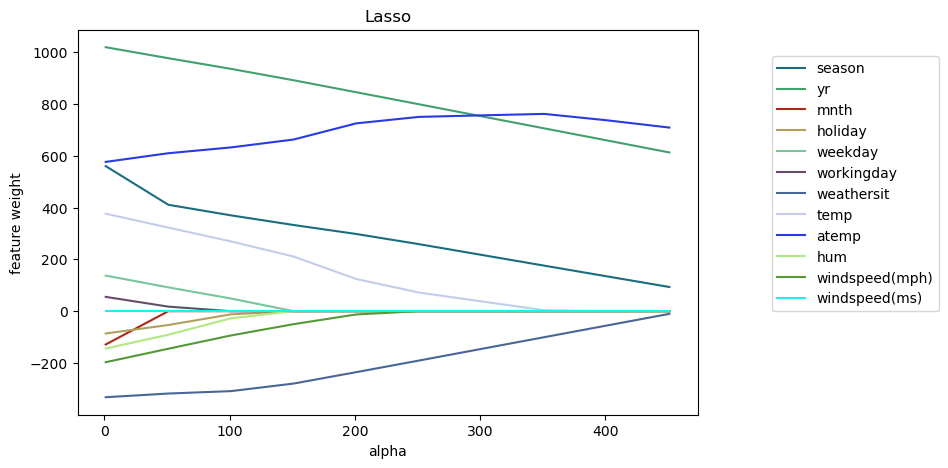

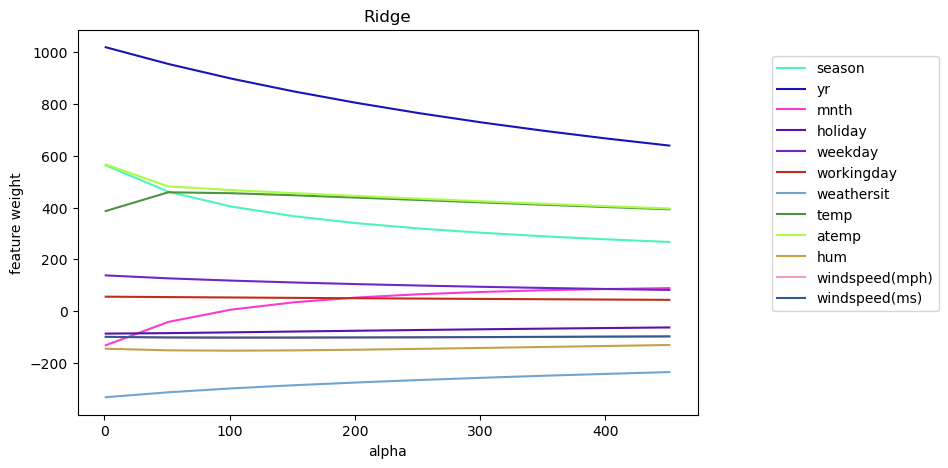

In [15]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при тому самому alpha?

Lasso

1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть чому так відбувається.

схоже, що ваги прямують до нуля. велике значення альфа змушує модель максимально спростити свої прогнози, "виключаючи" при цьому найменш важливі на його думку ознаки, все зануляючи їх внески

3. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` за будь-якого значення `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт за нього менше $10^{-3}$.

для лассо так, windspeed(ms), для рідж такого не бачу, схоже що він не зводить нічого в нуль і повільно зменшує

4. Який із регуляризаторів підійде для відбору неінформативних ознак?
   
однозначно лассо, яке вміє добре і швидко зануляти

### Завдання 8

Далі працюватимемо з `Lasso`.

Отже, бачимо, що зі зміною alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику функціонал з методом найменших квадратів, що сам оптимізується, тобто `Mean Square Error`.

По-друге, треба зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель робитиме передбачення нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити кілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднити MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і щоразу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn дуже просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список з alpha і кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор міститиме змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (кількість блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків . Крім того, в змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а coef\_, традиційно, навчені ваги, відповідні цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, в якому він проходить через alphas; Для порівняння з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` залежно від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [16]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

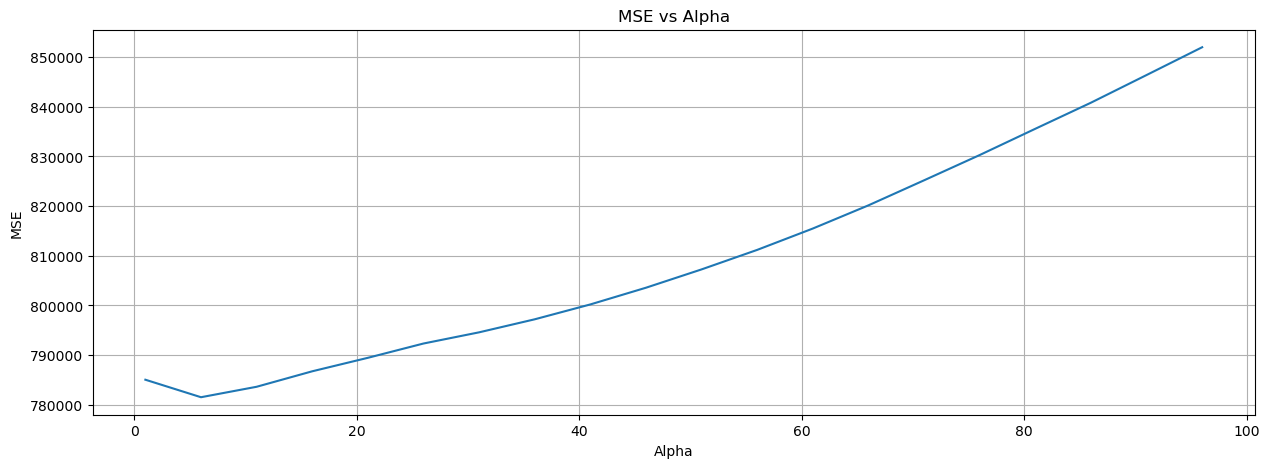

Selected alpha: 6
Feature-coefficient pairs: [('season', 532.0189828413534), ('yr', 1015.0602226430597), ('mnth', -100.03952614356612), ('holiday', -83.29395987529901), ('weekday', 132.50446549095804), ('workingday', 51.55708561407387), ('weathersit', -330.55985673998134), ('temp', 370.6798550300338), ('atemp', 581.3969310654983), ('hum', -140.00740550068866), ('windspeed(mph)', -191.77140847134908), ('windspeed(ms)', -2.6856312282124175e-08)]


In [17]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3)
regressor.fit(X, y)

mse_mean = np.mean(regressor.mse_path_, axis=1)
create_plot(list(zip(regressor.alphas_, mse_mean)), 'MSE vs Alpha', 'Alpha', 'MSE')

print("Selected alpha:", regressor.alpha_)

column_names = df_shuffled.columns  
print("Feature-coefficient pairs:", list(zip(column_names, regressor.coef_)))

# print("Feature-coefficient pairs:", list(zip(X.columns.tolist(), regressor.coef_))) 
# throws the following error:
# AttributeError                            Traceback (most recent call last)
# Cell In[24], line 14
#      12 column_names = df_shuffled.columns  
#      13 # print("Feature-coefficient pairs:", list(zip(column_names, regressor.coef_)))
# ---> 14 print("Feature-coefficient pairs:", list(zip(X.columns.tolist(), regressor.coef_)))

# AttributeError: 'numpy.ndarray' object has no attribute 'columns'


Отже, ми вибрали певний параметр регулювання. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто по стовпцях).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


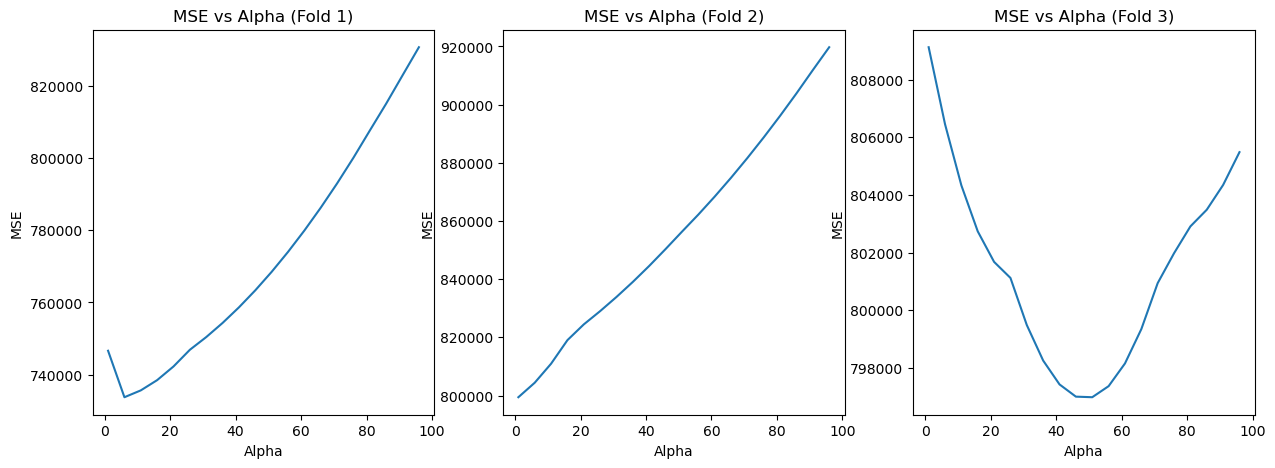

In [18]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(regressor.alphas_, regressor.mse_path_[:, 0])
plt.title('MSE vs Alpha (Fold 1)')
plt.xlabel('Alpha')
plt.ylabel('MSE')

plt.subplot(1, 3, 2)
plt.plot(regressor.alphas_, regressor.mse_path_[:, 1])
plt.title('MSE vs Alpha (Fold 2)')
plt.xlabel('Alpha')
plt.ylabel('MSE')

plt.subplot(1, 3, 3)
plt.plot(regressor.alphas_, regressor.mse_path_[:, 2])
plt.title('MSE vs Alpha (Fold 3)')
plt.xlabel('Alpha')
plt.ylabel('MSE')

plt.show()


На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємось на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо щось "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, проінтерпретуємо результат. Дайте відповідь на такі запитання.

#### Питання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей cnt від цих ознак, які ми малювали в блоці "Знайомство з даними". 

- Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? 

Відповідь: на мою думку лінійне наближення непогано описує залежність від температури. Можна провести чітку лінію посеред точок, щоби описати тенденцію. Дійсно, починаючи з певної температури варто очікувати нелінійний стрибок вниз. А якщо вже про лінійність є сенс говорити в певних межах (локально), то можна і сказати що від зими до осені попит росте також лінійно - а потім також різко "падає".  

- Чи логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

Відповідь: як я і сказала, можна непогано наблизити лінійною функцією значення температури - справді, чим тепліше на вулиці, тим більше людей будуть користуватись велосипедом. Це доволі очікувано, а за великим рахунком залежність від пори року це і є залежність від температури, тому це не дивно, що ці два графіки однакового характеру, і грубо можна наблизити лінійно. Насправді, мені здається що приріст людей від 0 до 10 градусів зовсім не такий самий, як від 10 до 20, тому я би пробувала гілку параболи. 

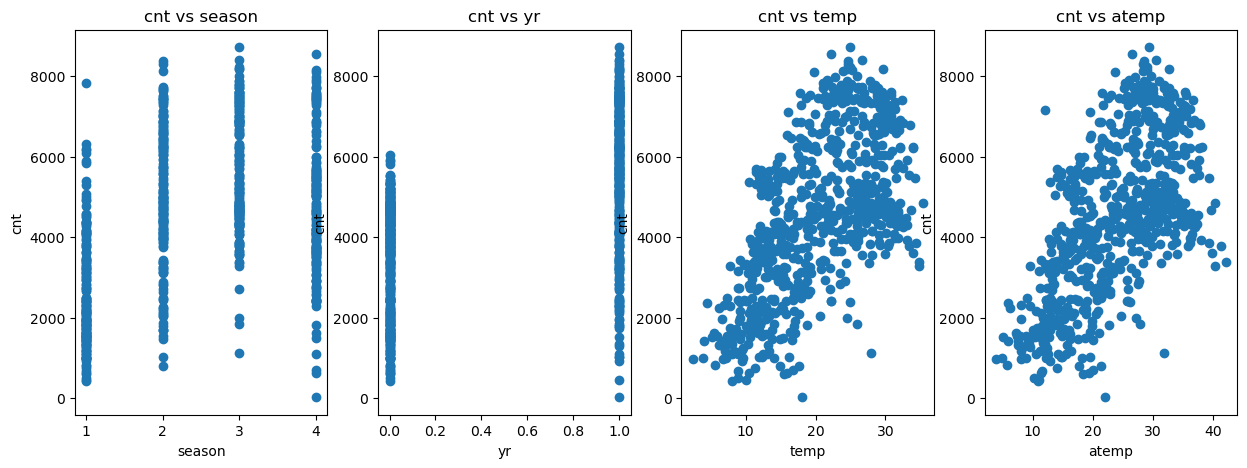

In [19]:
features_with_highest_coefficients = ['season', 'yr', 'temp', 'atemp']
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.scatter(df['season'], df['cnt'])
plt.title('cnt vs season')
plt.xlabel('season')
plt.ylabel('cnt')

plt.subplot(1, 4, 2)
plt.scatter(df['yr'], df['cnt'])
plt.title('cnt vs yr')
plt.xlabel('yr')
plt.ylabel('cnt')

plt.subplot(1, 4, 3)
plt.scatter(df['temp'], df['cnt'])
plt.title('cnt vs temp')
plt.xlabel('temp')
plt.ylabel('cnt')

plt.subplot(1, 4, 4)
plt.scatter(df['atemp'], df['cnt'])
plt.title('cnt vs atemp')
plt.xlabel('atemp')
plt.ylabel('cnt')

plt.show()


#### Питання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. 

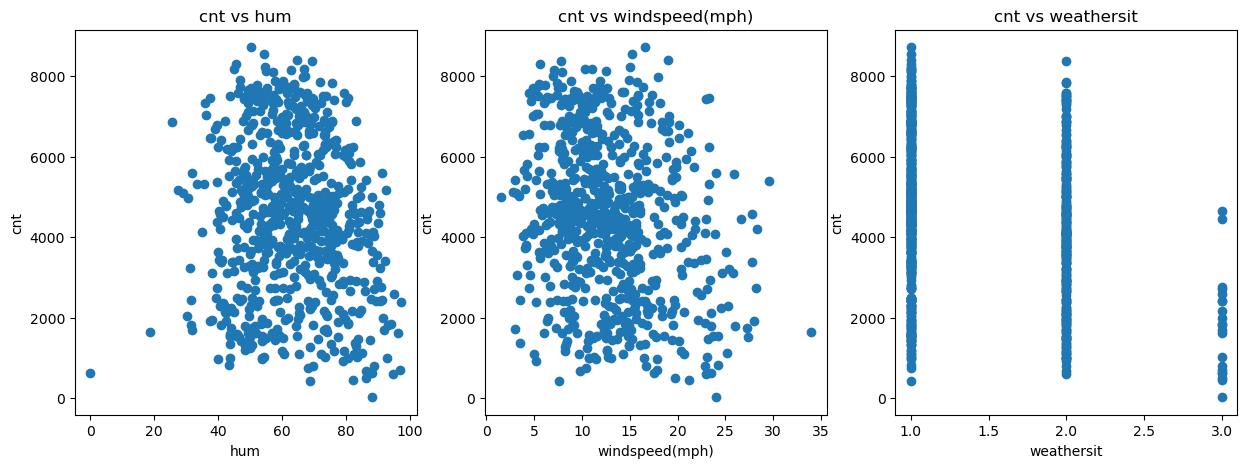

In [25]:
features_with_lowest_coefficients = ["hum", "windspeed(mph)", "weathersit"]
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(df["hum"], df["cnt"])
plt.title("cnt vs hum")
plt.xlabel("hum")
plt.ylabel("cnt")

plt.subplot(1, 3, 2)
plt.scatter(df["windspeed(mph)"], df["cnt"])
plt.title("cnt vs windspeed(mph)")
plt.xlabel("windspeed(mph)")
plt.ylabel("cnt")

plt.subplot(1, 3, 3)
plt.scatter(df["weathersit"], df["cnt"])
plt.title("cnt vs weathersit")
plt.xlabel("weathersit")
plt.ylabel("cnt")

plt.show()

- Чи видно обернено-пропорційну залежність? 
  
Так.

- Чи логічно стверджувати, що чим більші ці ознаки за модулем, тим менше буде попит на велосипеди?

Так, абсолютно, і це очікувано від таких параметрів, як швидкість вітру - чим вона більша, тим менше людей хочуть йти кататись. У вологості є пару точок-випадінь, але локально від 40 до 100 також різко падає, адже люди не сильно катаються в дощ, туман або сніг. 

#### Питання 3

Випишіть коефіцієнти, близькі до нуля (< 1e-3). 

Бачу тільки один такий.

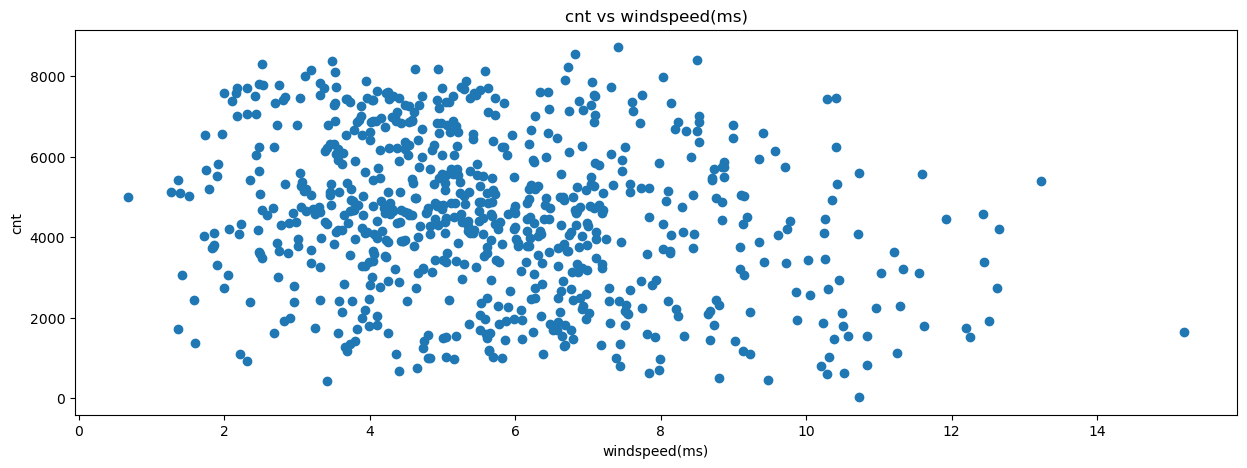

In [27]:
features_with_near_zero_coefficients = ["windspeed(ms)"]  
plt.figure(figsize=(15, 5))

plt.scatter(df["windspeed(ms)"], df["cnt"])
plt.title("cnt vs " + "windspeed(ms)")
plt.xlabel("windspeed(ms)")
plt.ylabel("cnt")


plt.show()

- Як ви думаєте, чому модель виключила їх з моделі (зверніть увагу на графіки)?

Відповідь: Така залежність найкраще буде описуватись функцією y = 4500 (конкретно це число - моя здогадка, спроба провести лінію посеред точок рівно), тобто cnt != cnt(windspeed).

- Чи вірно, що вони ніяк не впливають на попит на велосипеди? 

Відповідь: ні, не вірно, просто це така числова колізія утворилась в результаті використання цих одиниць, і тому ці дані збивають модель. В інших одиницях можемо уже бачити більш очікувану залежність.  

### Висновки

Отже, ми побачили як можна слідкувати за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, по можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелике число параментрів (до трьох), бо для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатись на великих обсягах даних. 